In [233]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import cmath
from numba import njit, f8,i8,c16
import numba
import matplotlib.animation as animation
import copy
import matplotlib

import sys
sys.path.append('../../lb')
import RungeKutta_acceralated

In [404]:
class Long_laminar:
    def __init__(self):
        self.arr = None
        self.arr = None
        self.average = None

    #微分方程式を定義
    @staticmethod
    @njit(cache=True)
    def henon(value, A = 3, B = 0.3, C = 5, D = 0.3, k = 0.4):
        """
        エノン写像
        
        """
        ddt_u = np.zeros((value.shape[0], 1), dtype = np.float64)
        """
        #微分方程式(4変数)
        ddt_u[0,:] = A - value[0,0]**2 + B * value[1,0] + k*(value[0,0] - value[2,0])
        ddt_u[1,:] = value[0,0]*1
        ddt_u[2,:] = C - value[2,0]**2 + D * value[3,0] + k * (value[2,0] - value[0,0])
        ddt_u[3,:] = value[2,0]*1
        """
        #微分方程式(2変数)
        a, b = 1.75, 0.3
        ddt_u[0,:] = a - (value[0,0] ** 2) + b * value[1,0]
        ddt_u[1,:] = value[0,0]
        return ddt_u
    
    #摂動()を与える　*時間は入れない*
    @staticmethod
    @njit(cache=True)
    def perturbator(array):
        a = -1
        b = -16
        s = (b - a) * np.random.rand() + a
        
        u = (2 * np.random.rand(array.shape[0],1) - 1) #本体は掛けない
        
        u_scaled = u / np.linalg.norm(u)
        
        return u_scaled * (10 ** s)  + array


    @staticmethod
    #@njit(cache=True)
    def get_arr_wrapped(func, period, start):
        """ 
        ある時点から指定秒数走らせる
        """ 
        arr = np.zeros((len(start[:,0])+1, period[1]+1),dtype=np.float64) #入れ物を作る
        n = period[0]
        arr[:-1,0:1] = start
        for i in range(period[1]): #ここのfor文でルンゲクッタ実行
            arr[:-1,i+1:i+2]=func(arr[:-1,i:i+1])
            n += 1
            arr[-1,i+1] = n
        return arr
    
    def get_arr(self, period, start):
        return Long_laminar.get_arr_wrapped(Long_laminar.henon, period, start)
            
    @staticmethod
    @njit(cache=True)
    def judge_laminar_for_a_while(func, check, progress, start):
        """ 
        ある時点から指定秒数走らせて、ラミナーに入っているかどうか指定秒を返す
        *startにはtが入ってる*
        """ 
        arr = np.zeros((start.shape[0], check+1),dtype=np.float64) #入れ物を作る
        n = start[-1,0]
        arr[:,0:1] = start
        for i in range(check): #ここのfor文でルンゲクッタ実行
            arr[:-1,i+1:i+2]=func(arr[:-1,i:i+1])
            n += 1
            arr[-1,i+1] = n
        

        if not (-4 < np.min(arr[:-1,:]) and np.max(arr[:-1,:])< 4):

            zero = np.zeros((len(arr[:,0]), progress+1), dtype = np.float64)
            return zero #ダメだったらゼロ行列を返す(numbaを使う上でreturnの型を統一しなければならない)
        
        return arr[:,:progress+1] #初期点も返す
    
    @staticmethod
    #@njit
    def get_laminar_wrapped(start, period, function, judge_laminar_for_a_while, perturbator, check, progress):
        dimention = len(start) #変数の次元
        
        arr = np.zeros((dimention+1,period[1]+1),dtype = np.float64) #器を作る
        arr[:-1,0:1] = start
        arr[-1,0] = period[0]
        i=0 #イテレーター
        perturbated_time = []
        
        while abs(arr[-1,-1]) == 0:
            dummy = judge_laminar_for_a_while(function, check, progress, arr[:,i:i+1])
            if not dummy[0,0] == 0:
                arr[:,i:i+len(dummy[0,:])] = dummy
                i += len(dummy[0,:]) - 1 #イテレータを次の初期値(今回の最後)まで持ってく
                print(dummy[:-1,-1])
            else:
                perturbated_time.append(abs(arr[-1,i]))
                counter = 0 #摂動を加えた回数のカウンター
                while True:
                    #摂動を加えた点pertubatedを作る
                    perturbated = arr[:,i:i+1].copy() #最終地点をコピってくる
                    counter += 1
                    if counter % 1E+5 == 0:
                        print(f"\r 摂動回数{counter}", end ="")
                    perturbated[:-1,:] = perturbator(perturbated[:-1,:]) #摂動を与える
                    dummy = judge_laminar_for_a_while(function, check, progress, arr[:,i:i+1])
                    if not dummy[-1,-1] == 0:
                        arr[:,i:i+len(dummy[0,:])] = dummy
                        i += len(dummy[0,:]) - 1 #イテレータを次の初期値(今回の最後)まで持ってく
                        print(dummy[:-1,-1],counter)
                        break
        return arr, perturbated_time
    def get_laminar(self, start, period, check, progress):
        self.arr, self.perturbated_time = Long_laminar.get_laminar_wrapped(start, period, Long_laminar.henon, Long_laminar.judge_laminar_for_a_while, Long_laminar.perturbator, check, progress)

In [336]:
runge_para = {
    'start' :  np.array([[0.9799609517046892], [1.0157131516544733]]),
    'period' : np.array([0,100])
}

In [369]:
runge_para['start'] = np.array([[1.1186466536503064], [0.4810534949735467]])

In [199]:
@njit(cache = True)
def inspecter(arr):
    for i in range(len(arr[0,:])):
        if not (-4 < np.min(arr[:-1,i]) and np.max(arr[:-1, i]) < 4):
            return arr[-1, i] - 1
    return arr[-1,-1]

In [325]:
np.set_printoptions(precision=16)

In [399]:
#初期値を生成&最高成績のもので更新
candidates = 1000
starts = np.zeros((len(runge_para['start'][:,0]),candidates))
for _ in range(5):
    starts[:,0:1] = runge_para['start']
    for i in range(candidates - 1):
        starts[:,i+1:i+2] = Long_laminar.perturbator(runge_para["start"])
    lmodel = Long_laminar()

    times = np.zeros(candidates)

    for i in range(candidates):
        runge_para["start"] = starts[:, i:i+1]
        arr = lmodel.get_arr(**runge_para)
        times[i] = inspecter(arr)
    runge_para['start'] = starts[:,np.argmax(times):np.argmax(times)+1]
    print(f'最大{np.max(times)},{runge_para["start"]}')
    if max(times) > runge_para["period"][1] * 0.99:
        break

最大89.0,[[ 1.5233410577484938]
 [-0.8534186453374502]]
最大89.0,[[ 1.5233410577484938]
 [-0.8534186453374502]]
最大89.0,[[ 1.5233410577484938]
 [-0.8534186453374502]]
最大89.0,[[ 1.5233410577484938]
 [-0.8534186453374502]]
最大89.0,[[ 1.5233410577484938]
 [-0.8534186453374502]]


In [65]:
#初期値を生成
#-2以上2未満の一様分布
runge_para['period'][1] = 10
candidates = 100000
starts = 8 * np.random.rand(len(runge_para['start'][:,0]), candidates) -4
lmodel = Long_laminar()

for i in tqdm(range(candidates)):
    runge_para["start"] = starts[:, i:i+1]
    arr = lmodel.get_arr(**runge_para)
    
    if -4 < np.min(arr[:-1,:]) and np.max(arr[:-1,:]) < 4:
        print(runge_para["start"])

 27%|█████████▏                        | 27082/100000 [00:14<00:39, 1829.11it/s]

[[ 1.63804616]
 [ 2.236243  ]
 [ 1.49218797]
 [-2.45351339]]


100%|█████████████████████████████████| 100000/100000 [00:57<00:00, 1732.56it/s]


In [403]:
#コンテスト
plt.figure(dpi=300)
candidates = 2000
runge_para['period'][1] = 93

starts = np.zeros((len(runge_para['start'][:,0]),candidates))
starts[:,0:1] = runge_para['start']
for i in range(candidates - 1):
    starts[:,i+1:i+2] = Long_laminar.perturbator(runge_para["start"])
lmodel = Long_laminar()

times = np.zeros(candidates)

count = 0

for i in range(candidates):
    runge_para["start"] = starts[:, i:i+1]
    arr = lmodel.get_arr(**runge_para)
    if  (-4 < np.min(arr[:-1,:]) and np.max(arr[:-1,:])< 4):
        #プロット
        ax1 = plt.subplot(2,1,1)
        ax1.plot(arr[-1,:],arr[0,:],lw=0.5)
        ax2 = plt.subplot(2,1,2)
        ax2.plot(arr[-1,:],arr[1,:],lw=0.5)
    else:
        count += 1
runge_para['start'] = starts[:,0:1]

<Figure size 1920x1440 with 0 Axes>

In [400]:
count

1675

# ラミナーに留まる

In [405]:
%%time
runge_para["period"]=np.array([0,100])

#刻み幅
check = 60
progress = 1

lmodel = Long_laminar()
lmodel.get_laminar(**runge_para, check = check, progress = progress)

[-0.8265935718235351  1.5233410577484938]
[ 1.5237453843445583 -0.8265935718235351]
[-0.8197780678584063  1.5237453843445583]
[ 1.5350875347617057 -0.8197780678584063]
[-0.8524271597382926  1.5350875347617057]
[ 1.483894197769019  -0.8524271597382926]
[-0.7076701380940483  1.483894197769019 ]
[ 1.6943712349806561 -0.7076701380940483]
[-1.3331949233580882  1.6943712349806561]
[ 0.4809026668264182 -1.3331949233580882]
[1.1187741480318125 0.4809026668264182]
[0.6426152057436175 1.1187741480318125]
[1.672677941756632  0.6426152057436175]
[-0.8550669351161175  1.672677941756632 ]
[ 1.5206639189981188 -0.8550669351161175]
[-0.8189388350775526  1.5206639189981188]
[ 1.5355383601012567 -0.8189388350775526]
[-0.8535597058657225  1.5355383601012567]
[ 1.482097336552798  -0.8535597058657225]
[-0.7026804267766147  1.482097336552798 ]
[ 1.7008694187908742 -0.7026804267766147]
[-1.3537609078109905  1.7008694187908742]
[ 0.4275922301200252 -1.3537609078109905]
[1.1610366123976863 0.4275922301200252]


KeyboardInterrupt: 

In [143]:
skip=100
plt.figure(figsize=(30,40))

for i in range(len(lmodel.arr[:-1,0])):
    plt.subplot(len(lmodel.arr[:-1,0]),1,i+1)
    plt.ylabel(f"u{i+1}")
    #plt.yscale=("log")
    plt.plot(np.real(lmodel.arr[-1,::skip]),abs(lmodel.arr[i,::skip]),lw=0.5)
    for j in range(len(lmodel.perturbated_time)):
        plt.vlines(x=lmodel.perturbated_time[j], ymin=np.min(abs(lmodel.arr[i,:])), ymax=np.max(abs(lmodel.arr[i,:])),colors="red")
#plt.savefig(fname=f"../laminar/nu{runge_para['nu']}_beta{beta}_{runge_para['step']}_{check}check_{progress}progress.png")

TypeError: 'NoneType' object is not subscriptable

<Figure size 3000x4000 with 0 Axes>

TypeError: 'NoneType' object is not subscriptable

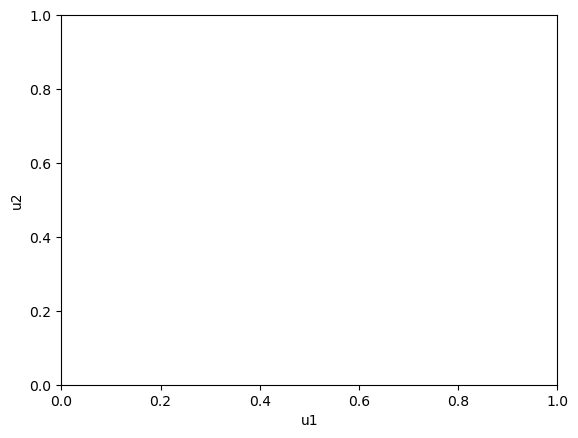

In [66]:
a, b = 0, 1
fig = plt.figure()
ax = plt.subplot(1,1,1)
ax.set_xlabel(f"u{a+1}")
ax.set_ylabel(f'u{b+1}')
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.plot(lmodel.arr[a,:2],lmodel.arr[b,:2],lw=0.01)
#plt.savefig(f"../laminar/nu{runge_para['nu']}_beta{beta}_{runge_para['step']}_{check}check_{progress}progress_u{a+1}&{b+1}.png")

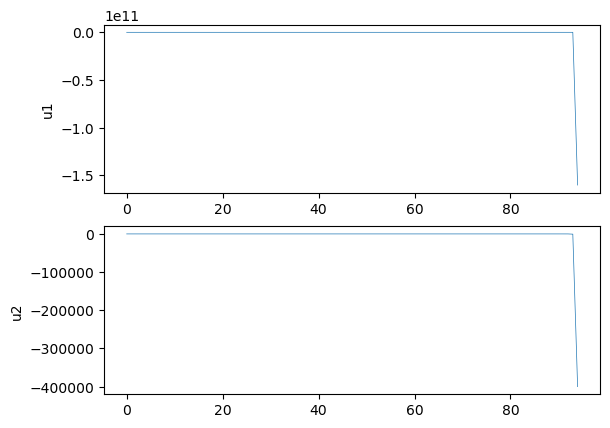

In [402]:
runge_para['period'][1] = 94
arr = lmodel.get_arr(**runge_para)
for i in range(len(arr[:-1,0])):
    plt.subplot(len(arr[:-1,0]),1,i+1)
    plt.ylabel(f"u{i+1}")
    #plt.yscale=("log")
    plt.plot(arr[-1,:],arr[i,:],lw=0.5)

In [398]:
runge_para['start'] = arr[:-1,4:5]

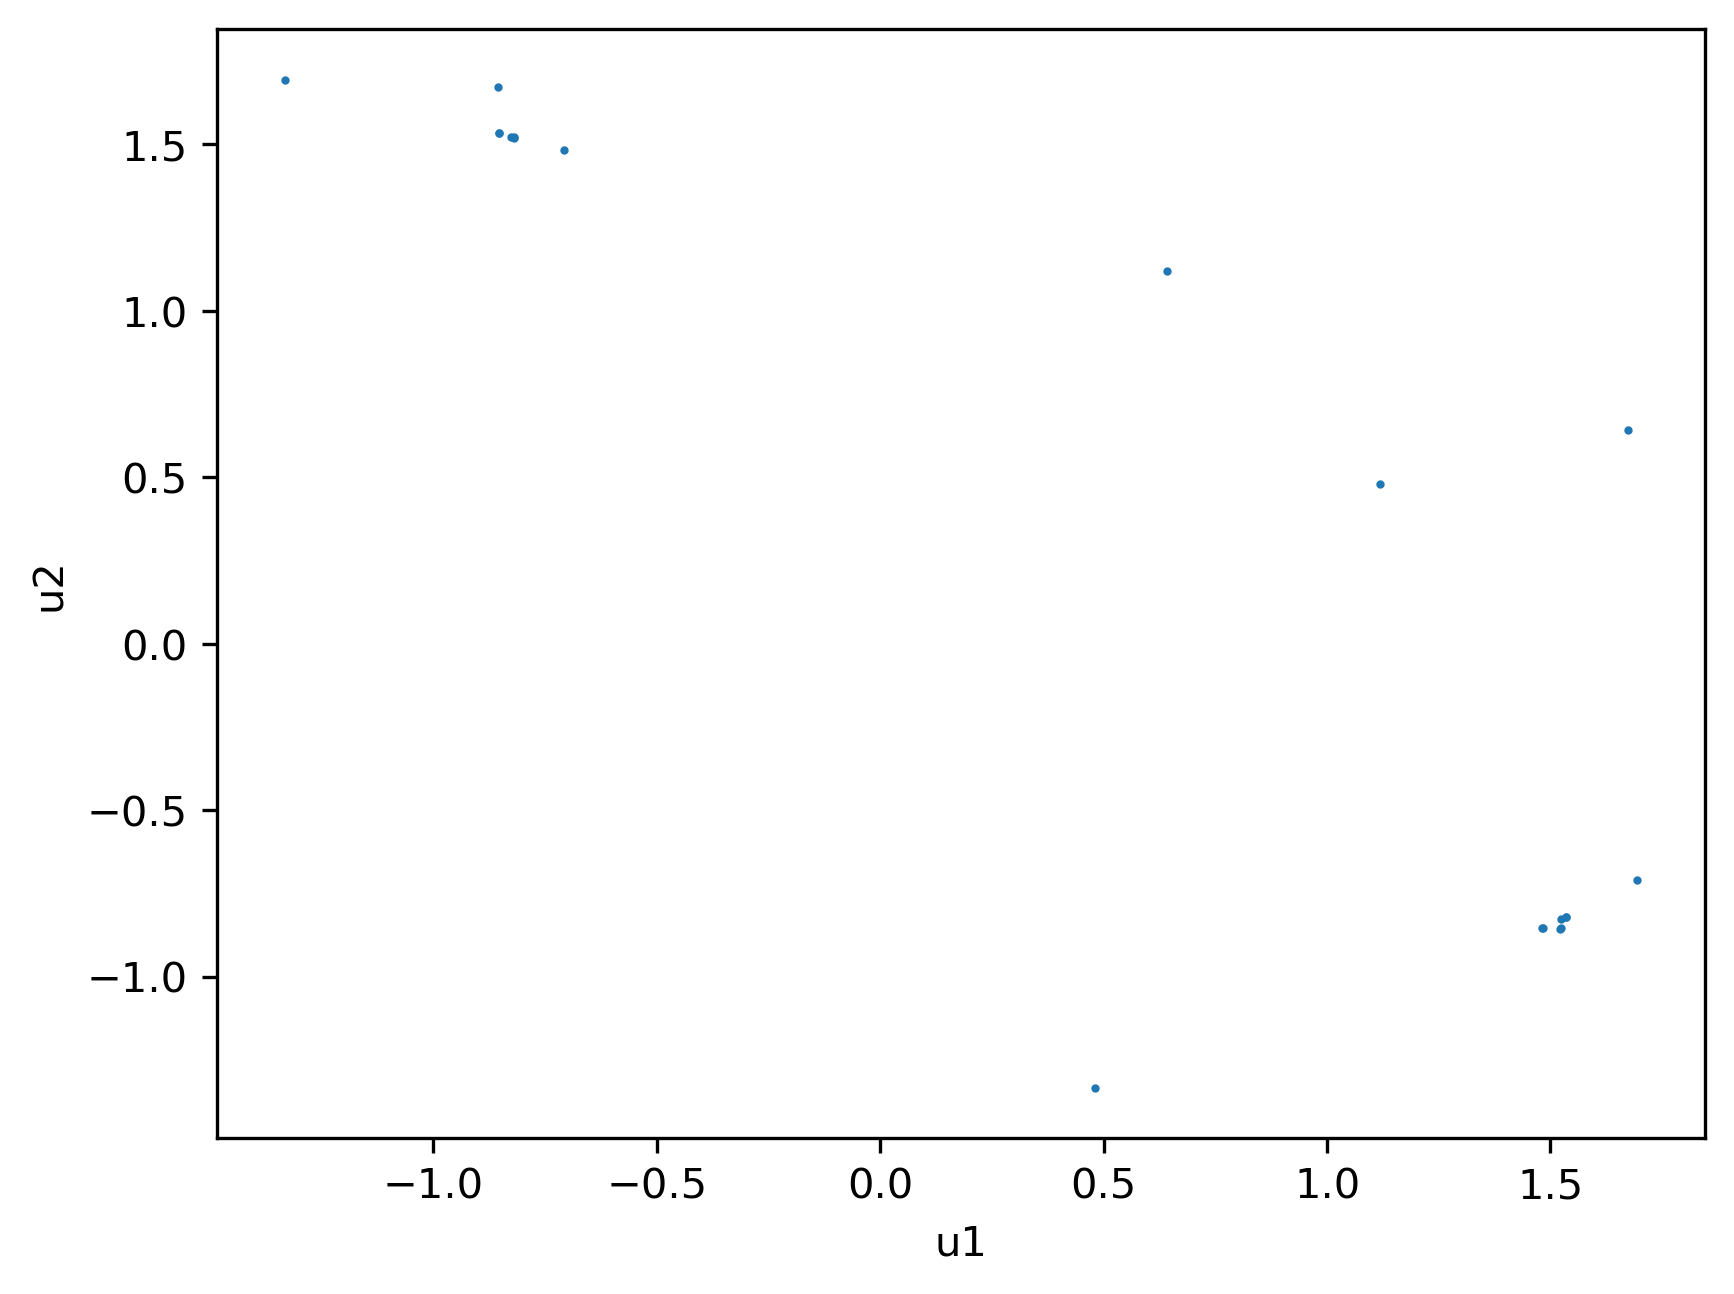

In [401]:
a, b = 0, 1
fig = plt.figure(dpi=300)
ax = plt.subplot(1,1,1)
ax.set_xlabel(f"u{a+1}")
ax.set_ylabel(f'u{b+1}')
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.scatter(arr[a,:20],arr[b,:20], s = 1)
#plt.savefig(f"../laminar/nu{runge_para['nu']}_beta{beta}_{runge_para['step']}_{check}check_{progress}progress_u{a+1}&{b+1}.png")